In [171]:
import wandb
import numpy as np
import pandas as pd
from collections import defaultdict

In [292]:
api = wandb.Api()

In [293]:
def extract_data(sweep):
    data = []
    for run in sweep.runs:
        params = run.config
        metrics = run.summary
        beta_2 = params['mi']['beta_2']
        pt_weight = params['mi']['pt_weight']
        encoder_mae = metrics.get('encoder_mae')
        encoder_reward = metrics.get('encoder_reward')
    
        data.append({
            'beta_2': beta_2,
            'pt_weight': pt_weight,
            'encoder_mae': encoder_mae,
            'encoder_reward': encoder_reward,
        })
    return data

# Teacher Prior influence

In [294]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

In [295]:
# teacher_sweep = api.sweep("kilian/LIFT/2tdtsniz")
# teacher_sweep = api.sweep("kilian/LIFT/1hdh4re3")
teacher_sweep = api.sweep("kilian/LIFT/g3zzbfp6")
teacher_data = extract_data(teacher_sweep)
df = pd.DataFrame(teacher_data)
len(teacher_data)

120

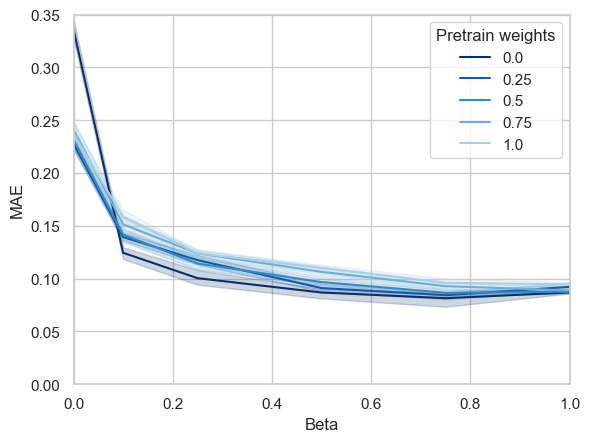

In [296]:
# sns.color_palette("tab10")
import matplotlib.colors as mcolors
norm = mcolors.Normalize(vmin=0, vmax=1.5)

sns.lineplot(data=df, x='beta_2', y='encoder_mae', hue='pt_weight', palette='Blues_r', hue_norm=norm)
plt.xlabel('Beta')
plt.ylabel('MAE')
plt.legend(title='Pretrain weights')
plt.xlim(0,1)
plt.ylim(0.0, 0.35)
# plt.savefig('../figures/teacher_importance.png', dpi=400)

We have some different options here. First, we need a baseline grid which is only copying the teacher.
Then, we can have one grid with small kl + mi + pt, one with mi+pt, one with mi only
Then we can chose the most interesting
parameters can be pt_weight = 0.5
and kl_weight = 0.2 or 1.0 with mse

Order:
1. baseline
2. mi + 0.5 pt
3. mi + 0.5 pt + ?? kl
4. mi only (this could also be in form of teacher importance)

Keeping a bit of the pretrain data (i.e. 0.25) seems to be slightly better than discarding it completely for high betas.

## MI experiments

In [297]:
import wandb
import numpy as np
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

In [298]:
api = wandb.Api()

In [299]:
def extract_data(sweep):
    data = []
    for run in sweep.runs:
        params = run.config
        metrics = run.summary
        encoder_mae = metrics.get('encoder_mae')
        encoder_reward = metrics.get('encoder_reward')
    
        data.append({
            'noise': params['noise'],
            'noise_slope': params['noise_slope'],
            'alpha': params['alpha'],
            'mode': "teacher" if params['mi']['only_copy_teacher'] else f"KL_{params['mi']['beta_2']}",
            'encoder_mae': encoder_mae,
            'encoder_reward': encoder_reward,
        })
    return data

In [300]:
# teacher_sweep = api.sweep("kilian/LIFT/pvhti95q")
teacher_sweep = api.sweep("kilian/LIFT/he8odg2h")
teacher_sweep_2 = api.sweep("kilian/LIFT/fw3337wk")
mi_sweep = api.sweep("kilian/LIFT/iatusjy9")
mi_sweep_2 = api.sweep("kilian/LIFT/0mnd6asn")
mi_sweep_medium = api.sweep("kilian/LIFT/onfirt08")
teacher_data = extract_data(teacher_sweep)
mi_data = extract_data(mi_sweep)
teacher_data_2 = extract_data(teacher_sweep_2)
mi_data_2 = extract_data(mi_sweep_2)
mi_data_medium = extract_data(mi_sweep_medium)
data = teacher_data + mi_data + teacher_data_2 + mi_data_2 + mi_data_medium
df = pd.DataFrame(data)
len(data)

800

In [301]:
df.head()

,noise,noise_slope,alpha,mode,encoder_mae,encoder_reward
0,1.0,1.00,3,teacher,0.281734,-0.045509
1,1.0,1.00,3,teacher,0.275833,-0.043812
2,1.0,0.75,3,teacher,0.219637,-0.038476
3,1.0,0.50,3,teacher,0.287374,-0.034509
4,1.0,0.75,3,teacher,0.203582,-0.035366


In [302]:
df['mode'].unique()
for mode in df['mode'].unique():
    print(mode)
    print(len(df[df['mode'] == mode]))
    print(df[df['mode'] == mode]['encoder_mae'].mean())

teacher
200
0.19420209081843495
KL_1
200
0.18240372151136397
KL_0.1
200
0.18722476255148648
KL_0.5
200
0.1798639540746808


In [303]:
0.1942 / 0.1798

1.0800889877641826

In [304]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

In [305]:
5*5*2*4*2

400

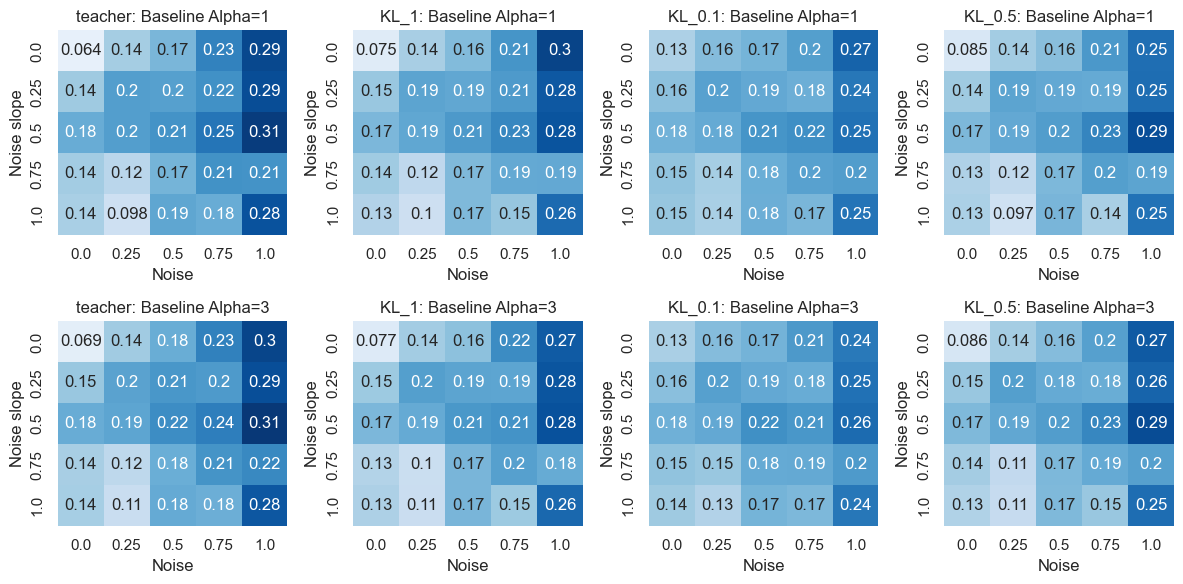

In [306]:
fig, axs = plt.subplots(2, len(df['mode'].unique()), figsize=(12, 6))

for i, training_mode in enumerate(df['mode'].unique()):
    mode_df = df[df['mode'] == training_mode]
    mode_heatmap = mode_df[mode_df['alpha'] == 1.0][['noise', 'noise_slope', 'encoder_mae']].groupby(['noise', 'noise_slope']).mean().reset_index()
    df_grouped = mode_heatmap.groupby(['noise', 'noise_slope'], as_index=False).mean()
    mode_heatmap_data_1 = df_grouped.pivot(index='noise_slope', columns='noise', values='encoder_mae')

    mode_heatmap_3 = mode_df[mode_df['alpha'] == 3.0][['noise', 'noise_slope', 'encoder_mae']].groupby(['noise', 'noise_slope']).mean().reset_index()
    df_grouped_3 = mode_heatmap_3.groupby(['noise', 'noise_slope'], as_index=False).mean()
    mode_heatmap_data_3 = df_grouped_3.pivot(index='noise_slope', columns='noise', values='encoder_mae')

    sns.heatmap(mode_heatmap_data_1, annot=True, cmap='Blues', ax=axs[0, i], cbar=False, vmin=0.04, vmax=0.32)
    axs[0, i].set_title(f'{training_mode}: Baseline Alpha=1')
    axs[0, i].set_xlabel('Noise')
    axs[0, i].set_ylabel('Noise slope')

    sns.heatmap(mode_heatmap_data_3, annot=True, cmap='Blues', ax=axs[1, i], cbar=False, vmin=0.04, vmax=0.32)
    axs[1, i].set_title(f'{training_mode}: Baseline Alpha=3')
    axs[1, i].set_xlabel('Noise')
    axs[1, i].set_ylabel('Noise slope')

plt.tight_layout()
plt.show()

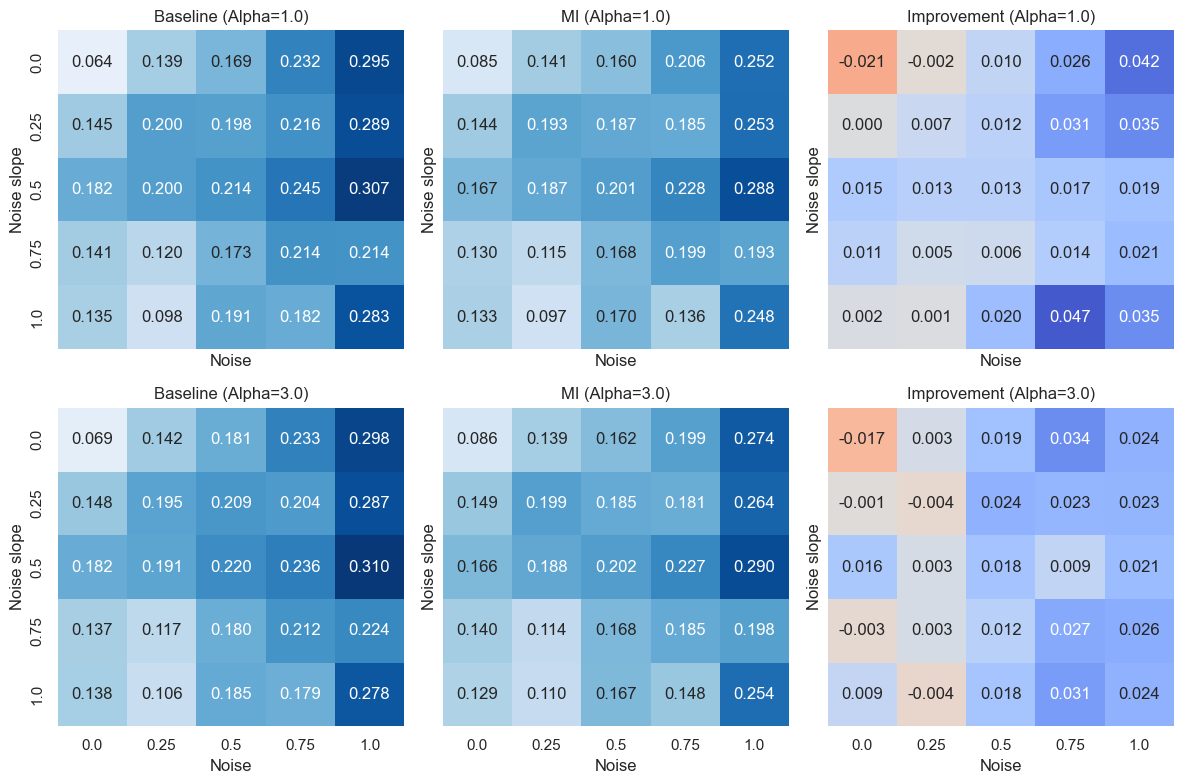

In [336]:
kl_mode = 'KL_0.5'
alphas = [1.0, 3.0]

fig, axs = plt.subplots(2, 3, figsize=(12, 8), sharex=True, sharey=True)

# for i, training_mode in enumerate(df['mode'].unique()):
for i, alpha in enumerate(alphas):
    mode_df = df[df['mode'] == "teacher"]
    mode_heatmap = mode_df[mode_df['alpha'] == alpha][['noise', 'noise_slope', 'encoder_mae']].groupby(['noise', 'noise_slope']).mean().reset_index()
    df_grouped_teacher = mode_heatmap.groupby(['noise', 'noise_slope'], as_index=False).mean()
    teacher_heatmap_data = df_grouped_teacher.pivot(index='noise_slope', columns='noise', values='encoder_mae')

    sns.heatmap(teacher_heatmap_data, annot=True, fmt=".3f", cmap='Blues', ax=axs[i, 0], cbar=False, vmin=0.04, vmax=0.32)
    axs[i, 0].set_title(f'Baseline (Alpha={alpha})')
    axs[i, 0].set_xlabel('Noise')
    axs[i, 0].set_ylabel('Noise slope')

    mode_df = df[df['mode'] == kl_mode]
    mode_heatmap = mode_df[mode_df['alpha'] == alpha][['noise', 'noise_slope', 'encoder_mae']].groupby(['noise', 'noise_slope']).mean().reset_index()
    df_grouped_kl = mode_heatmap.groupby(['noise', 'noise_slope'], as_index=False).mean()
    kl_heatmap_data = df_grouped_kl.pivot(index='noise_slope', columns='noise', values='encoder_mae')

    sns.heatmap(kl_heatmap_data, annot=True, fmt=".3f", cmap='Blues', ax=axs[i, 1], cbar=False, vmin=0.04, vmax=0.32)
    axs[i, 1].set_title(f'MI (Alpha={alpha})')
    axs[i, 1].set_xlabel('Noise')
    axs[i, 1].set_ylabel('Noise slope')

    df_grouped_kl['diff'] = (df_grouped_teacher.encoder_mae - df_grouped_kl.encoder_mae).values
    diff_data = df_grouped_kl.pivot(index='noise_slope', columns='noise', values='diff')

    sns.heatmap(diff_data, annot=True, fmt=".3f", cmap='coolwarm_r', ax=axs[i, 2], cbar=False, vmin=-0.05, vmax=0.05)
    axs[i, 2].set_title(f'Improvement (Alpha={alpha})')
    axs[i, 2].set_xlabel('Noise')
    axs[i, 2].set_ylabel('Noise slope')

plt.tight_layout()
plt.show()

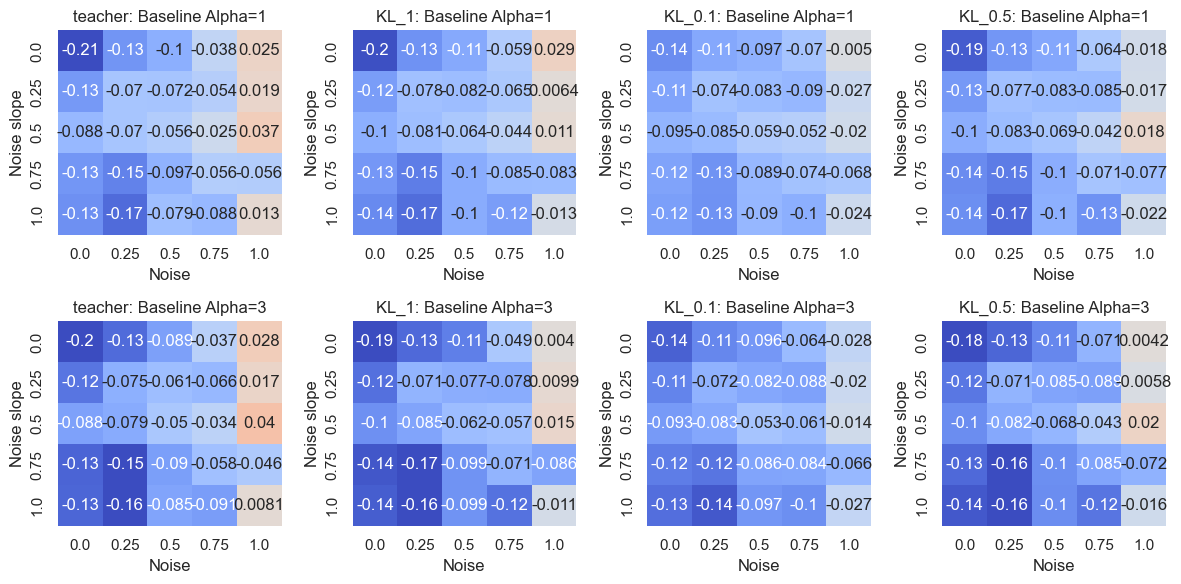

In [308]:
fig, axs = plt.subplots(2, len(df['mode'].unique()), figsize=(12, 6))

for i, training_mode in enumerate(df['mode'].unique()):
    mode_df = df[df['mode'] == training_mode]
    mode_heatmap = mode_df[mode_df['alpha'] == 1.0][['noise', 'noise_slope', 'encoder_mae']].groupby(['noise', 'noise_slope']).mean().reset_index()
    mode_heatmap['encoder_mae'] -= 0.27  # TODO calculate the true pt baseline
    df_grouped = mode_heatmap.groupby(['noise', 'noise_slope'], as_index=False).mean()
    mode_heatmap_data_1 = df_grouped.pivot(index='noise_slope', columns='noise', values='encoder_mae')

    mode_heatmap_3 = mode_df[mode_df['alpha'] == 3.0][['noise', 'noise_slope', 'encoder_mae']].groupby(['noise', 'noise_slope']).mean().reset_index()
    mode_heatmap_3['encoder_mae'] -= 0.27
    df_grouped_3 = mode_heatmap_3.groupby(['noise', 'noise_slope'], as_index=False).mean()
    mode_heatmap_data_3 = df_grouped_3.pivot(index='noise_slope', columns='noise', values='encoder_mae')


    sns.heatmap(mode_heatmap_data_1, annot=True, cmap='coolwarm', ax=axs[0, i], cbar=False, vmin=-.2, vmax=0.2)
    axs[0, i].set_title(f'{training_mode}: Baseline Alpha=1')
    axs[0, i].set_xlabel('Noise')
    axs[0, i].set_ylabel('Noise slope')

    sns.heatmap(mode_heatmap_data_3, annot=True, cmap='coolwarm', ax=axs[1, i], cbar=False, vmin=-.15, vmax=0.15)
    axs[1, i].set_title(f'{training_mode}: Baseline Alpha=3')
    axs[1, i].set_xlabel('Noise')
    axs[1, i].set_ylabel('Noise slope')

plt.tight_layout()
plt.show()

In [309]:
alpha_1 = 1.0
baseline_df = df[df['mode'] == 'teacher']
mi_df = df[df['mode'] == 'KL_1']
mi_alpha_df = mi_df[mi_df['alpha'] == alpha_1][['noise', 'noise_slope', 'encoder_mae']]
baseline_alpha_df = baseline_df[baseline_df['alpha'] == alpha_1][['noise', 'noise_slope', 'encoder_mae']]

baseline_df_grouped = baseline_alpha_df.groupby(['noise', 'noise_slope'], as_index=False).mean()
mi_alpha_df_grouped = mi_alpha_df.groupby(['noise', 'noise_slope'], as_index=False).mean()

max_change = (baseline_df_grouped.encoder_mae - mi_alpha_df_grouped.encoder_mae).max()
max_improve_idx = (baseline_df_grouped.encoder_mae - mi_alpha_df_grouped.encoder_mae).argmax()

(max_change * 100) / baseline_df_grouped.encoder_mae[max_improve_idx]

18.035308105213044

In [312]:
alpha_1 = 1.0
baseline_df = df[df['mode'] == 'teacher']
mi_df = df[df['mode'] == 'KL_0.5']
mi_alpha_df = mi_df[mi_df['alpha'] == alpha_1][['noise', 'noise_slope', 'encoder_mae']]
baseline_alpha_df = baseline_df[baseline_df['alpha'] == alpha_1][['noise', 'noise_slope', 'encoder_mae']]

baseline_df_grouped = baseline_alpha_df.groupby(['noise', 'noise_slope'], as_index=False).mean()
mi_alpha_df_grouped = mi_alpha_df.groupby(['noise', 'noise_slope'], as_index=False).mean()

max_change = (baseline_df_grouped.encoder_mae - mi_alpha_df_grouped.encoder_mae).max()
max_improve_idx = (baseline_df_grouped.encoder_mae - mi_alpha_df_grouped.encoder_mae).argmax()

(max_change * 100) / baseline_df_grouped.encoder_mae[max_improve_idx]

25.620604275267205

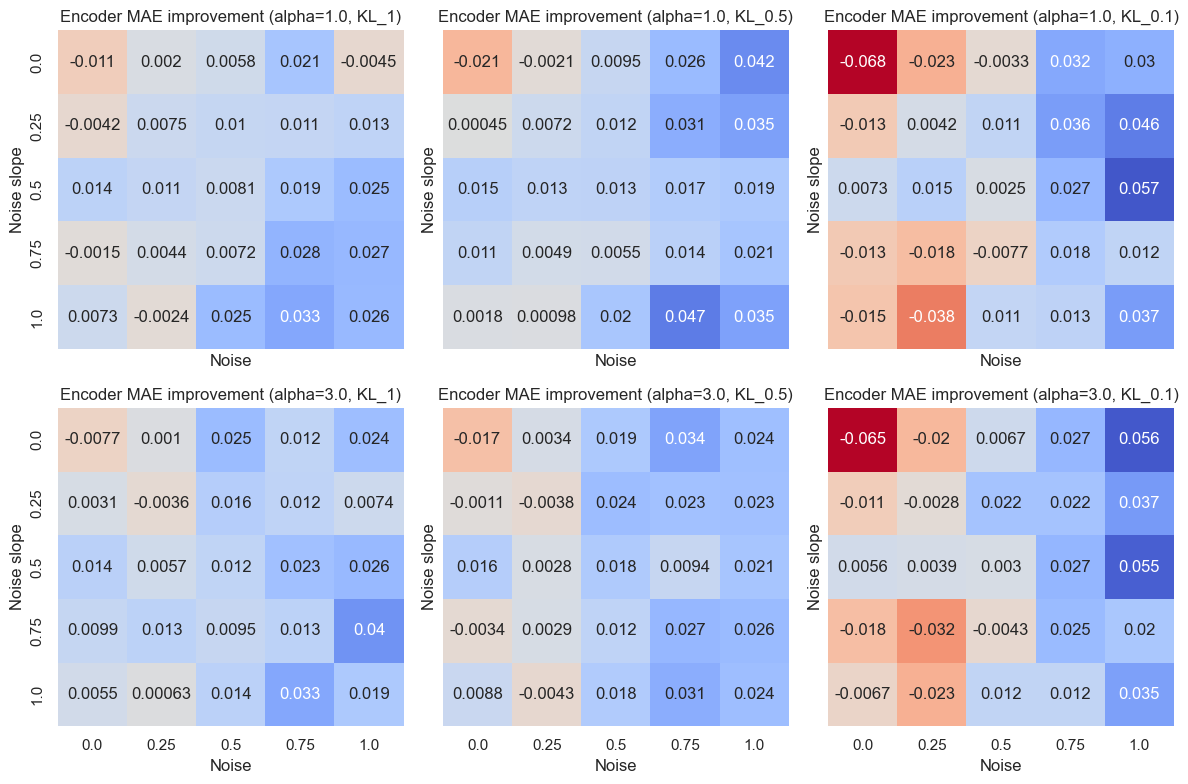

In [315]:
fig, axs = plt.subplots(2, 3, figsize=(12, 8), sharex=True, sharey=True)

baseline_df = df[df['mode'] == 'teacher']

for i, kl_mode in enumerate(['KL_1', 'KL_0.5', 'KL_0.1']):
    mi_df = df[df['mode'] == kl_mode]

    alpha_1 = 1.0
    mi_alpha_df = mi_df[mi_df['alpha'] == alpha_1][['noise', 'noise_slope', 'encoder_mae']]
    baseline_alpha_df = baseline_df[baseline_df['alpha'] == alpha_1][['noise', 'noise_slope', 'encoder_mae']]

    baseline_df_grouped = baseline_alpha_df.groupby(['noise', 'noise_slope'], as_index=False).mean()
    mi_alpha_df_grouped = mi_alpha_df.groupby(['noise', 'noise_slope'], as_index=False).mean()

    mi_alpha_df_grouped['diff'] = (baseline_df_grouped.encoder_mae - mi_alpha_df_grouped.encoder_mae).values
    heatmap_data_1 = mi_alpha_df_grouped.pivot(index='noise_slope', columns='noise', values='diff')

    alpha_3 = 3.0
    mi_alpha_df = mi_df[mi_df['alpha'] == alpha_3][['noise', 'noise_slope', 'encoder_mae']]
    baseline_alpha_df = baseline_df[baseline_df['alpha'] == alpha_3][['noise', 'noise_slope', 'encoder_mae']]

    baseline_df_grouped = baseline_alpha_df.groupby(['noise', 'noise_slope'], as_index=False).mean()
    mi_alpha_df_grouped = mi_alpha_df.groupby(['noise', 'noise_slope'], as_index=False).mean()

    mi_alpha_df_grouped['diff'] = (baseline_df_grouped.encoder_mae - mi_alpha_df_grouped.encoder_mae).values
    heatmap_data_3 = mi_alpha_df_grouped.pivot(index='noise_slope', columns='noise', values='diff')

    # Plot the heatmap
    sns.heatmap(heatmap_data_1, annot=True, cmap='coolwarm_r', ax=axs[0, i], cbar=False, vmin=-0.06, vmax=0.06)
    axs[0, i].set_title(f'Encoder MAE improvement (alpha={alpha_1}, {kl_mode})')
    axs[0, i].set_xlabel('Noise')
    axs[0, i].set_ylabel('Noise slope')

    sns.heatmap(heatmap_data_3, annot=True, cmap='coolwarm_r', ax=axs[1, i], cbar=False, vmin=-0.06, vmax=0.06)
    axs[1, i].set_title(f'Encoder MAE improvement (alpha={alpha_3}, {kl_mode})')
    axs[1, i].set_xlabel('Noise')
    axs[1, i].set_ylabel('Noise slope')

plt.tight_layout()
plt.show()

In [321]:
base_mean = baseline_df.encoder_mae.mean()
mi_df = df[df['mode'] == 'KL_1']
mi_mean = mi_df.encoder_mae.mean()
mean_d_mae = base_mean - mi_mean
mean_d_mae

0.011798369307070983

In [322]:
base_mean = baseline_df.encoder_mae.mean()
mi_df = df[df['mode'] == 'KL_0.1']
mi_mean = mi_df.encoder_mae.mean()
mean_d_mae = base_mean - mi_mean
mean_d_mae

0.006977328266948468

In [323]:
base_mean = baseline_df.encoder_mae.mean()
mi_df = df[df['mode'] == 'KL_0.5']
mi_mean = mi_df.encoder_mae.mean()
mean_d_mae = base_mean - mi_mean
mean_d_mae

0.014338136743754143

In [324]:
(mean_d_mae * 100) / base_mean

7.383101120759444

# Long runs (10 sessions, 5k and 10k rollouts)

In [341]:
def extract_data_long(sweep):
    data = []
    for run in sweep.runs:
        params = run.config
        metrics = run.summary
        encoder_mae = metrics.get('encoder_mae')
        encoder_reward = metrics.get('encoder_reward')
    
        data.append({
            'noise': params['noise'],
            'noise_slope': params['noise_slope'],
            'alpha': params['alpha'],
            'n_rollout': params['mi']['n_steps_rollout'],
            'mode': "teacher" if params['mi']['only_copy_teacher'] else f"KL_{params['mi']['beta_2']}",
            'encoder_mae': encoder_mae,
            'encoder_reward': encoder_reward,
        })
    return data

In [363]:
teacher_sweep_long = api.sweep("kilian/LIFT/qakme0i9")
mi_sweep_long = api.sweep("kilian/LIFT/w9de2w6q")
teacher_data_long = extract_data_long(teacher_sweep_long)
mi_data_long = extract_data_long(mi_sweep_long)
data_long = teacher_data_long + mi_data_long
df_long = pd.DataFrame(data_long)
len(data_long)

1198

In [364]:
df_long.head()

,noise,noise_slope,alpha,n_rollout,mode,encoder_mae,encoder_reward
0,0.5,0.75,3,5000,teacher,0.174938,-0.028472
1,0.5,0.50,3,5000,teacher,0.205394,-0.030901
2,0.5,0.50,3,5000,teacher,0.219167,-0.027357
3,0.5,0.50,3,5000,teacher,0.227986,-0.028572
4,0.5,0.25,3,5000,teacher,0.188540,-0.030518


In [365]:
df_long['n_rollout'].unique()

array([ 5000, 10000])

In [372]:
df_long[(df_long['mode'] == 'teacher') & (df_long['n_rollout'] == 5_000)]['encoder_mae'].mean(), df_long[(df_long['mode'] == 'teacher') & (df_long['n_rollout'] == 10_000)]['encoder_mae'].mean()

(0.18193576216697693, 0.178562148604542)

In [374]:
df_long[(df_long['mode'] == 'KL_0.1') & (df_long['n_rollout'] == 5_000)]['encoder_mae'].mean(), df_long[(df_long['mode'] == 'KL_0.1') & (df_long['n_rollout'] == 10_000)]['encoder_mae'].mean()

(0.18186027828603982, 0.18176552198827267)

In [373]:
df_long[(df_long['mode'] == 'KL_1') & (df_long['n_rollout'] == 5_000)]['encoder_mae'].mean(), df_long[(df_long['mode'] == 'KL_1') & (df_long['n_rollout'] == 10_000)]['encoder_mae'].mean()

(0.17823955338448286, 0.18022679815990755)

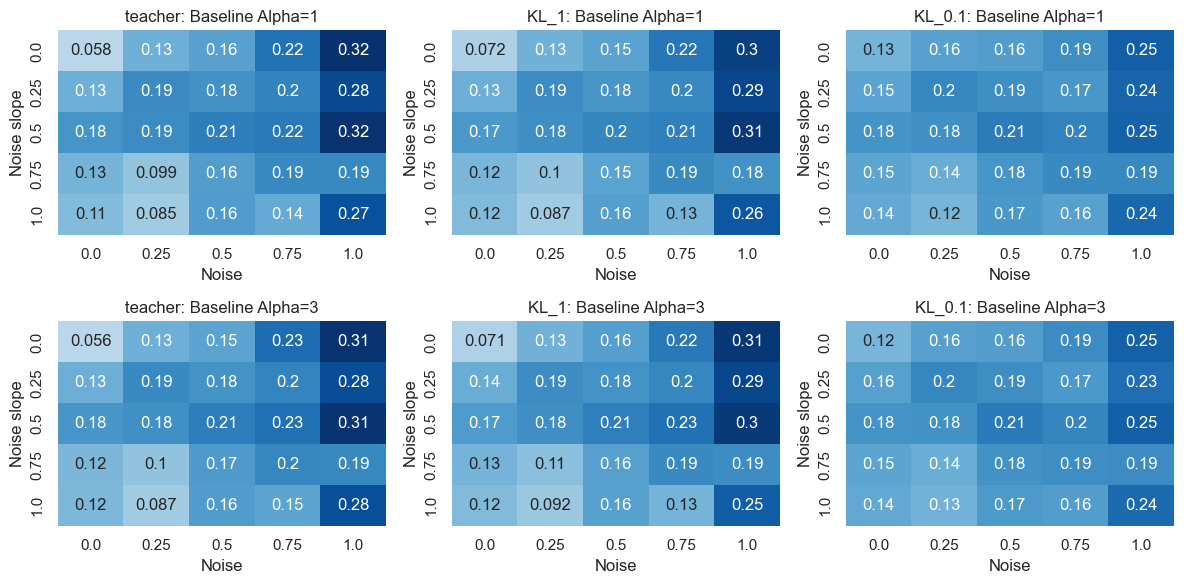

In [377]:
df_5000 = df_long[df_long['n_rollout'] == 5_000]
fig, axs = plt.subplots(2, len(df_5000['mode'].unique()), figsize=(12, 6))

for i, training_mode in enumerate(df_5000['mode'].unique()):
    mode_df = df_5000[df_5000['mode'] == training_mode]
    mode_heatmap = mode_df[mode_df['alpha'] == 1.0][['noise', 'noise_slope', 'encoder_mae']].groupby(['noise', 'noise_slope']).mean().reset_index()
    # mode_heatmap['encoder_mae'] -= 0.27  # TODO calculate the true pt baseline
    df_grouped = mode_heatmap.groupby(['noise', 'noise_slope'], as_index=False).mean()
    mode_heatmap_data_1 = df_grouped.pivot(index='noise_slope', columns='noise', values='encoder_mae')

    mode_heatmap_3 = mode_df[mode_df['alpha'] == 3.0][['noise', 'noise_slope', 'encoder_mae']].groupby(['noise', 'noise_slope']).mean().reset_index()
    # mode_heatmap_3['encoder_mae'] -= 0.27
    df_grouped_3 = mode_heatmap_3.groupby(['noise', 'noise_slope'], as_index=False).mean()
    mode_heatmap_data_3 = df_grouped_3.pivot(index='noise_slope', columns='noise', values='encoder_mae')


    sns.heatmap(mode_heatmap_data_1, annot=True, cmap='Blues', ax=axs[0, i], cbar=False, vmin=-.05, vmax=0.32)
    axs[0, i].set_title(f'{training_mode}: Baseline Alpha=1')
    axs[0, i].set_xlabel('Noise')
    axs[0, i].set_ylabel('Noise slope')

    sns.heatmap(mode_heatmap_data_3, annot=True, cmap='Blues', ax=axs[1, i], cbar=False, vmin=-.05, vmax=0.32)
    axs[1, i].set_title(f'{training_mode}: Baseline Alpha=3')
    axs[1, i].set_xlabel('Noise')
    axs[1, i].set_ylabel('Noise slope')

plt.tight_layout()
plt.show()

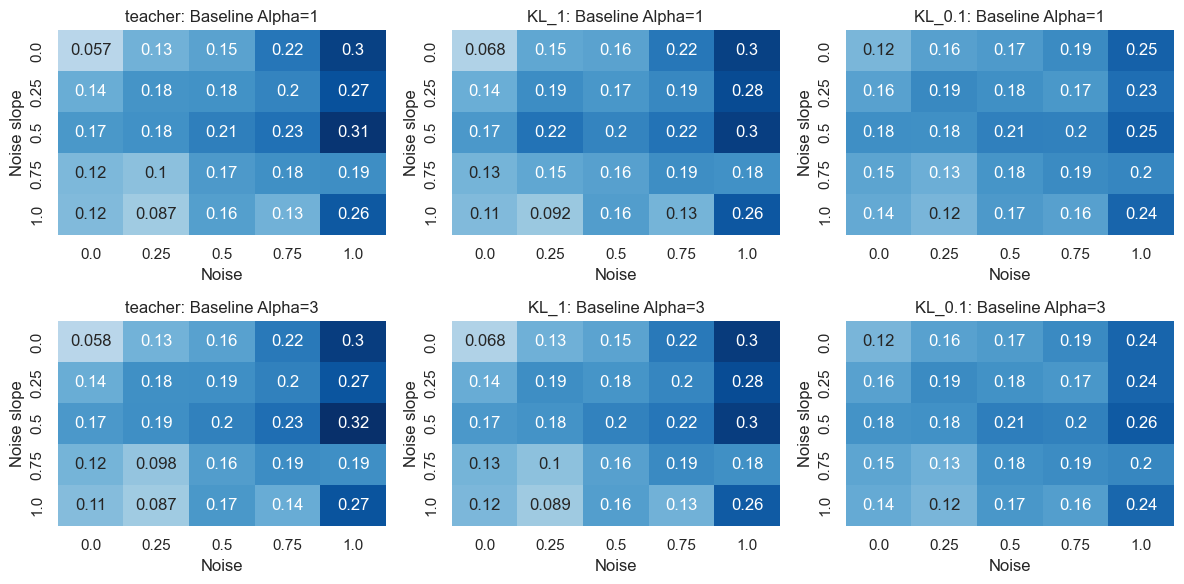

In [378]:
df_5000 = df_long[df_long['n_rollout'] == 10_000]
fig, axs = plt.subplots(2, len(df_5000['mode'].unique()), figsize=(12, 6))

for i, training_mode in enumerate(df_5000['mode'].unique()):
    mode_df = df_5000[df_5000['mode'] == training_mode]
    mode_heatmap = mode_df[mode_df['alpha'] == 1.0][['noise', 'noise_slope', 'encoder_mae']].groupby(['noise', 'noise_slope']).mean().reset_index()
    # mode_heatmap['encoder_mae'] -= 0.27  # TODO calculate the true pt baseline
    df_grouped = mode_heatmap.groupby(['noise', 'noise_slope'], as_index=False).mean()
    mode_heatmap_data_1 = df_grouped.pivot(index='noise_slope', columns='noise', values='encoder_mae')

    mode_heatmap_3 = mode_df[mode_df['alpha'] == 3.0][['noise', 'noise_slope', 'encoder_mae']].groupby(['noise', 'noise_slope']).mean().reset_index()
    # mode_heatmap_3['encoder_mae'] -= 0.27
    df_grouped_3 = mode_heatmap_3.groupby(['noise', 'noise_slope'], as_index=False).mean()
    mode_heatmap_data_3 = df_grouped_3.pivot(index='noise_slope', columns='noise', values='encoder_mae')


    sns.heatmap(mode_heatmap_data_1, annot=True, cmap='Blues', ax=axs[0, i], cbar=False, vmin=-.05, vmax=0.32)
    axs[0, i].set_title(f'{training_mode}: Baseline Alpha=1')
    axs[0, i].set_xlabel('Noise')
    axs[0, i].set_ylabel('Noise slope')

    sns.heatmap(mode_heatmap_data_3, annot=True, cmap='Blues', ax=axs[1, i], cbar=False, vmin=-.05, vmax=0.32)
    axs[1, i].set_title(f'{training_mode}: Baseline Alpha=3')
    axs[1, i].set_xlabel('Noise')
    axs[1, i].set_ylabel('Noise slope')

plt.tight_layout()
plt.show()

# Deprecated

# MI Iter

In [382]:
# Filter runs by the "beta_sweep" tag
base_runs = [run for run in runs if "baseline" in run.tags and run.state == "finished"]

# Output the filtered runs
print(f"Found {len(base_runs)} runs with the tag 'mi_sweep'.")

Found 4 runs with the tag 'mi_sweep'.


In [383]:
baseline_data = defaultdict(list)

for run in base_runs:
    run_id = run.id
    history = run.history(samples=10000)
    run_results = {
        "seed": run.config["seed"],
        "noise": run.config["noise_range"][-1],
        "rewards": history.encoder_reward.values,
        "maes": history.encoder_mae.values,
        "mean_rewards": np.nanmean(history.encoder_reward.values[1:]),
        "last_rewards": np.nanmean(history.encoder_reward.values[-3:]),
        "mean_mae": np.nanmean(history.encoder_mae.values[1:]),
        "last_mae": np.nanmean(history.encoder_mae.values[-3:]),
    }
    for key, value in run_results.items():
        baseline_data[key].append(value)

raw_base_df = pd.DataFrame(baseline_data)
base_df = raw_base_df.groupby(['noise']).mean()

In [295]:
base_df.mean_rewards

noise
1   -0.044931
Name: mean_rewards, dtype: float64

In [296]:
# Filter runs by the "beta_sweep" tag
mi_sweep_runs = [run for run in runs if "mi_sweep_kl05" in run.tags and run.state == "finished"]

# Output the filtered runs
print(f"Found {len(mi_sweep_runs)} runs with the tag 'mi_sweep'.")

Found 200 runs with the tag 'mi_sweep'.


In [297]:
run_data = defaultdict(list)

for run in mi_sweep_runs:
    run_id = run.id
    history = run.history(samples=10000)
    run_results = {
        "seed": run.config["seed"],
        "noise": run.config["noise_range"][-1],
        "noise_slope": run.config["noise_slope_range"][-1],
        "alpha": run.config["alpha_range"][-1],
        "rewards": history.encoder_reward.values,
        "maes": history.encoder_mae.values,
        "mean_rewards": np.nanmean(history.encoder_reward.values[1:]),
        "last_rewards": np.nanmean(history.encoder_reward.values[-3:]),
        "mean_mae": np.nanmean(history.encoder_mae.values[1:]),
        "last_mae": np.nanmean(history.encoder_mae.values[-3:]),
    }
    for key, value in run_results.items():
        run_data[key].append(value)

raw_df = pd.DataFrame(run_data)

assert (raw_df.groupby(['noise', 'noise_slope', 'alpha']).size().values == 4).all(), "Not all runs have the same number of seeds"

df = raw_df.groupby(['noise', 'noise_slope', 'alpha']).mean().reset_index()

In [384]:
df_a1 = df[df['alpha'] == 1.0]
df_a3 = df[df['alpha'] == 3.0]

In [299]:
base_df.mean_rewards.values[0]

-0.044930609831557264

In [333]:
df.mean_rewards.max()

-0.029301131299224056

In [300]:
max_rwd_increase = base_df.mean_rewards.values[0] - df.mean_rewards.max()
p_increase = max_rwd_increase / base_df.mean_rewards.values[0]
print(f"max reward increse: {max_rwd_increase:.3f}, percentage increase: {p_increase:.3f}")

max reward increse: -0.016, percentage increase: 0.348


In [301]:
better_than_base_p = np.mean([a > base_df.mean_rewards.values[0] for a in df.mean_rewards.values])
better_than_base_p

0.68

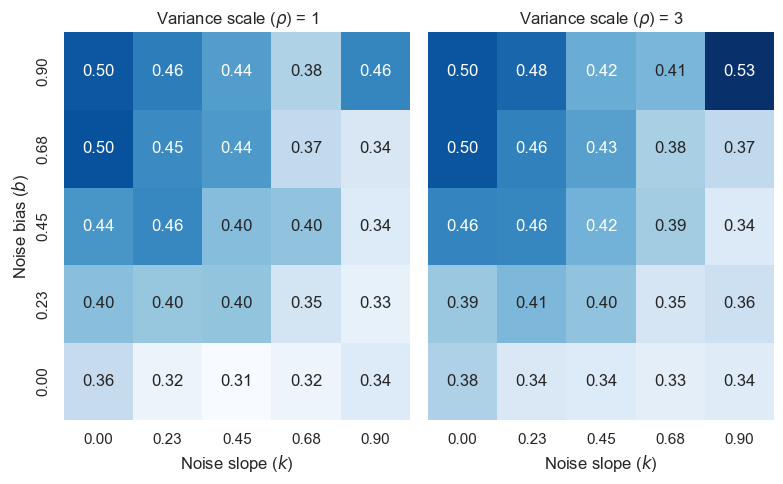

In [401]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(1, 2, figsize=(8, 5), sharey=True)

cmap = 'Blues'
vmin = df.mean_mae.min()
vmax = df.mean_mae.max()

df_a1_plot = df_a1.pivot(index='noise', columns='noise_slope', values='mean_mae').sort_index(ascending=False)
df_a3_plot = df_a3.pivot(index='noise', columns='noise_slope', values='mean_mae').sort_index(ascending=False)
sns.heatmap(df_a1_plot,
            annot=True, cbar=False, fmt=".2f", cmap=cmap, ax=axs[0], vmin=vmin, vmax=vmax)
sns.heatmap(df_a3_plot,
            annot=True, cbar=False, fmt=".2f", cmap=cmap, ax=axs[1], vmin=vmin, vmax=vmax)

# axs[0].set_title(r"Mean MAE ($\rho=1$)")
# axs[1].set_title(r"Mean MAE ($\rho=3$)")
axs[0].set_title(r"Variance scale ($\rho$) = 1")
axs[1].set_title(r"Variance scale ($\rho$) = 3")

# round ticks
axs[0].set_xticklabels([f"{x:.2f}" for x in df_a1_plot.index.sort_values()])
axs[0].set_yticklabels([f"{x:.2f}" for x in df_a1_plot.columns.sort_values(ascending=False)])
axs[1].set_xticklabels([f"{x:.2f}" for x in df_a3_plot.index.sort_values()])

axs[0].set_xlabel(r"Noise slope ($k$)")
axs[0].set_ylabel(r"Noise bias ($b$)")
axs[1].set_xlabel(r"Noise slope ($k$)")
axs[1].set_ylabel("")


plt.tight_layout()
plt.savefig('../figures/mi_iter_mean_mae.png', dpi=400)
plt.show()

# TODO make same as others before and add subplot titles 

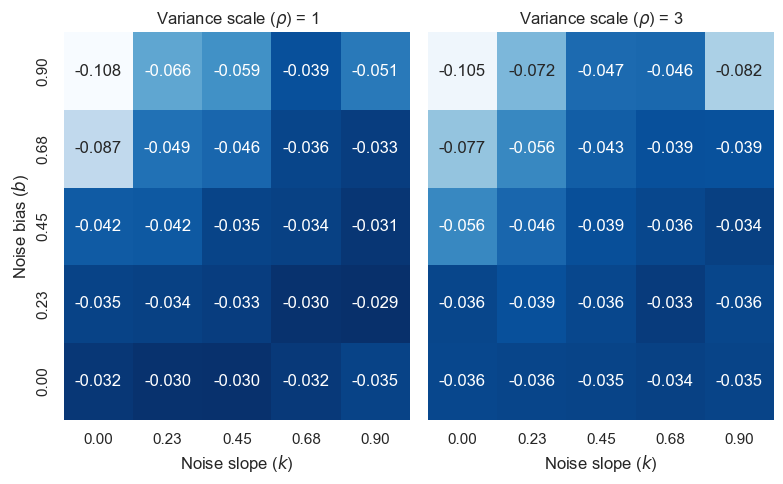

In [385]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(1, 2, figsize=(8, 5), sharey=True)

cmap = 'Blues'
vmin = df.mean_rewards.min()
vmax = df.mean_rewards.max()

df_a1_plot = df_a1.pivot(index='noise', columns='noise_slope', values='mean_rewards').sort_index(ascending=False)
df_a3_plot = df_a3.pivot(index='noise', columns='noise_slope', values='mean_rewards').sort_index(ascending=False)
sns.heatmap(df_a1_plot,
            annot=True, cbar=False, fmt=".3f", cmap=cmap, ax=axs[0], vmin=vmin, vmax=vmax)
sns.heatmap(df_a3_plot,
            annot=True, cbar=False, fmt=".3f", cmap=cmap, ax=axs[1], vmin=vmin, vmax=vmax)

# axs[0].set_title(r"Mean reward ($\rho=1$)")
# axs[1].set_title(r"Mean reward ($\rho=3$)")
axs[0].set_title(r"Variance scale ($\rho$) = 1")
axs[1].set_title(r"Variance scale ($\rho$) = 3")


# round ticks
axs[0].set_xticklabels([f"{x:.2f}" for x in df_a1_plot.index.sort_values()])
axs[0].set_yticklabels([f"{x:.2f}" for x in df_a1_plot.columns.sort_values(ascending=False)])
axs[1].set_xticklabels([f"{x:.2f}" for x in df_a3_plot.index.sort_values()])

axs[0].set_xlabel(r"Noise slope ($k$)")
axs[0].set_ylabel(r"Noise bias ($b$)")
axs[1].set_xlabel(r"Noise slope ($k$)")
axs[1].set_ylabel("")

plt.tight_layout()
plt.savefig('../figures/mi_iter_mean_reward.png', dpi=400)
plt.show()

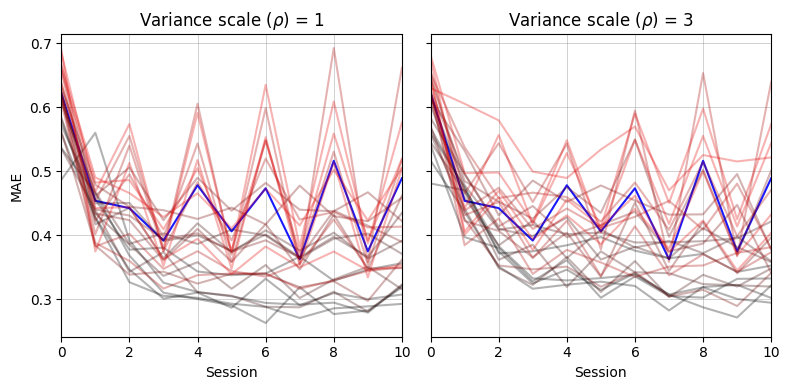

In [307]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4), sharey=True)

# plot baseline
base_color = (.1, .1, 1.)
base_mae = base_df.maes.values[0]
base_mae = base_mae[~np.isnan(base_mae)]
axs[0].plot(base_mae, color=base_color, alpha=1.0, zorder=2)
axs[1].plot(base_mae, color=base_color, alpha=1.0, zorder=2)

for i, rwd in enumerate(df_a1.maes.values):
    rwd = rwd[~np.isnan(rwd)]
    noise = df_a1.iloc[i].noise
    color = (noise, 0, 0)
    axs[0].plot(rwd, color=color, alpha=0.3, zorder=2)

for i, rwd in enumerate(df_a3.maes.values):
    rwd = rwd[~np.isnan(rwd)]
    noise = df_a3.iloc[i].noise
    color = (noise, 0, 0)
    axs[1].plot(rwd, color=color, alpha=0.3, zorder=2)

axs[0].set_xlabel("Session")
axs[0].set_ylabel("MAE")
axs[0].set_title(r"Variance scale ($\rho$) = 1")
axs[1].set_xlabel("Session")
# axs[1].set_ylabel("reward")
axs[1].set_title(r"Variance scale ($\rho$) = 3")

# add grid in background
axs[0].grid(color='gray', linestyle='-', linewidth=0.5, alpha=0.5, zorder=1)
axs[1].grid(color='gray', linestyle='-', linewidth=0.5, alpha=0.5, zorder=1)
axs[0].set_axisbelow(True)
axs[0].set_xlim(0, 10)
# axs[0].set_ylim(0, 1.)
axs[1].set_xlim(0, 10)

# Show the plot
plt.tight_layout()
plt.savefig('../figures/mi_iter_per_episode.png', dpi=400)
plt.show()

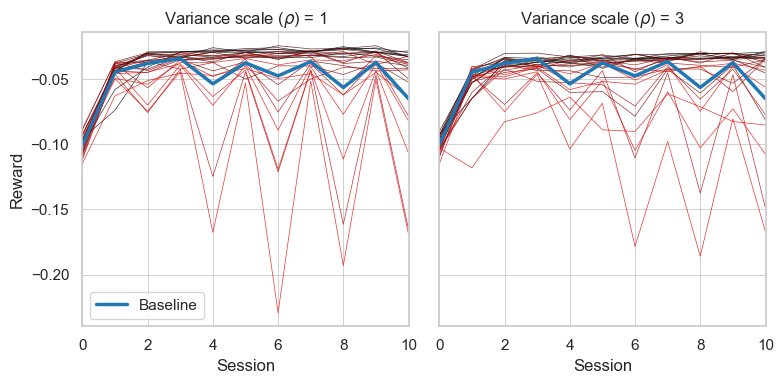

In [345]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4), sharey=True)

for i, rwd in enumerate(df_a1.rewards.values):
    rwd = rwd[~np.isnan(rwd)]
    noise = df_a1.iloc[i].noise
    color = (noise, 0, 0)
    axs[0].plot(rwd, color=color, alpha=0.8, zorder=2, linewidth=.5)

for i, rwd in enumerate(df_a3.rewards.values):
    rwd = rwd[~np.isnan(rwd)]
    noise = df_a3.iloc[i].noise
    color = (noise, 0, 0)
    axs[1].plot(rwd, color=color, alpha=0.8, zorder=2, linewidth=.5)

# plot baseline
base_color = "tab:blue"#(.2, .2, .9)
base_reward = base_df.rewards.values[0]
base_reward = base_reward[~np.isnan(base_reward)]
axs[0].plot(base_reward, color=base_color, alpha=1.0, zorder=2, linewidth=2.5, label='Baseline')
axs[1].plot(base_reward, color=base_color, alpha=1.0, zorder=2, linewidth=2.5, label='Baseline')

axs[0].set_xlabel("Session")
axs[0].set_ylabel("Reward")
axs[0].set_title(r"Variance scale ($\rho$) = 1")
axs[1].set_xlabel("Session")
# axs[1].set_ylabel("reward")
axs[1].set_title(r"Variance scale ($\rho$) = 3")

# add grid in background
axs[0].grid(color='gray', linestyle='-', linewidth=0.5, alpha=0.5, zorder=1)
axs[1].grid(color='gray', linestyle='-', linewidth=0.5, alpha=0.5, zorder=1)
axs[0].set_axisbelow(True)
axs[0].set_xlim(0, 10)
# axs[0].set_ylim(0, 1.)
axs[1].set_xlim(0, 10)

axs[0].legend()

# Show the plot
plt.tight_layout()
plt.savefig('../figures/mi_iter_rwd_per_episode.png', dpi=400)
plt.show()

# Conditioned baseline

In [472]:
# Filter runs by the "beta_sweep" tag
cond_baseline_runs = [run for run in runs if "baseline_v2" in run.tags and run.state == "finished"]

# Output the filtered runs
print(f"Found {len(cond_baseline_runs)} runs with the tag 'mi_sweep'.")

Found 66 runs with the tag 'mi_sweep'.


In [473]:
cond_baseline_data = defaultdict(list)

for run in cond_baseline_runs:
    run_id = run.id
    history = run.history(samples=10000)
    run_results = {
        "noise": run.config["noise_range"][-1],
        "noise_slope": run.config["noise_slope_range"][-1],
        "alpha": run.config["alpha_range"][-1],
        "rewards": history.encoder_reward.values,
        "maes": history.encoder_mae.values,
        "mean_rewards": np.nanmean(history.encoder_reward.values[1:]),
        "last_rewards": np.nanmean(history.encoder_reward.values[-3:]),
        "mean_mae": np.nanmean(history.encoder_mae.values[1:]),
        "last_mae": np.nanmean(history.encoder_mae.values[-3:]),
    }
    for key, value in run_results.items():
        cond_baseline_data[key].append(value)

raw_cond_baseline_df = pd.DataFrame(cond_baseline_data)

cond_baseline_df = raw_cond_baseline_df.groupby(['noise', 'noise_slope', 'alpha']).mean().reset_index()

In [474]:
cond_baseline_df_a1 = cond_baseline_df[cond_baseline_df['alpha'] == 1.0]
cond_baseline_df_a3 = cond_baseline_df[cond_baseline_df['alpha'] == 3.0]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


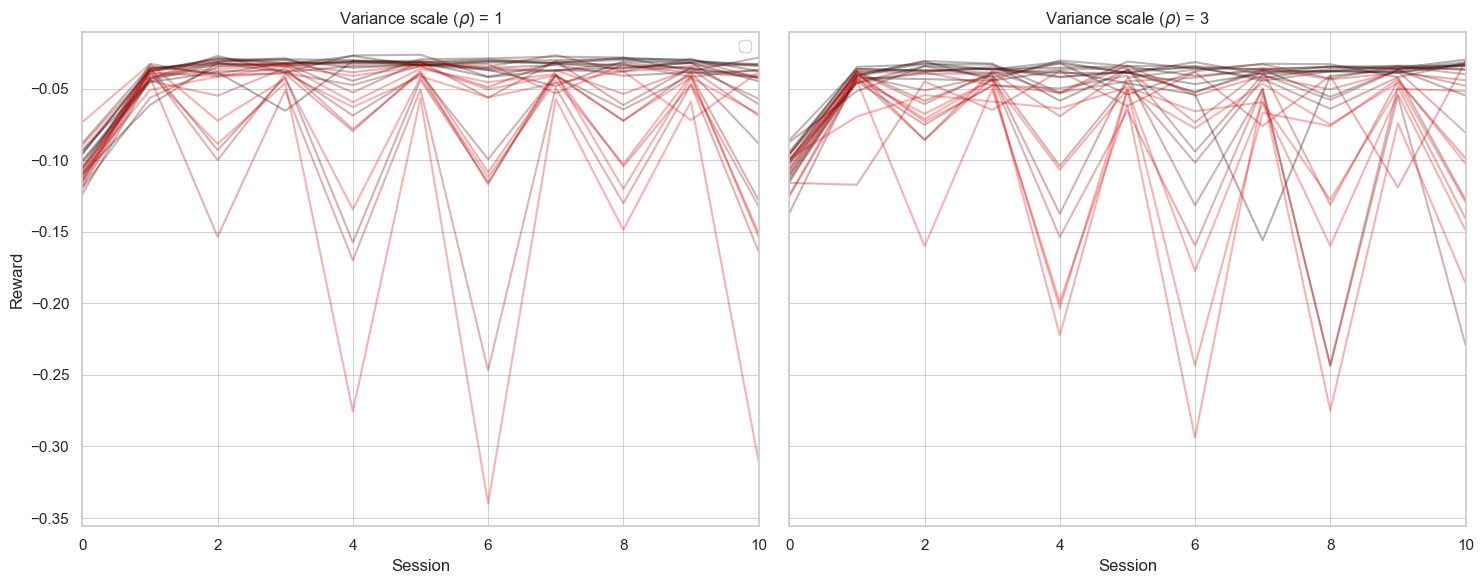

In [475]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6), sharey=True)

for i, rwd in enumerate(cond_baseline_df_a1.rewards.values):
    rwd = rwd[~np.isnan(rwd)]
    noise = cond_baseline_df_a1.iloc[i].noise
    color = (noise, 0, 0)
    axs[0].plot(rwd, color=color, alpha=0.3, zorder=2)

for i, rwd in enumerate(cond_baseline_df_a3.rewards.values):
    rwd = rwd[~np.isnan(rwd)]
    noise = cond_baseline_df_a3.iloc[i].noise
    color = (noise, 0, 0)
    axs[1].plot(rwd, color=color, alpha=0.3, zorder=2)

axs[0].set_xlabel("Session")
axs[0].set_ylabel("Reward")
axs[0].set_title(r"Variance scale ($\rho$) = 1")
axs[1].set_xlabel("Session")
# axs[1].set_ylabel("reward")
axs[1].set_title(r"Variance scale ($\rho$) = 3")

# add grid in background
axs[0].grid(color='gray', linestyle='-', linewidth=0.5, alpha=0.5, zorder=1)
axs[1].grid(color='gray', linestyle='-', linewidth=0.5, alpha=0.5, zorder=1)
axs[0].set_axisbelow(True)
axs[0].set_xlim(0, 10)
# axs[0].set_ylim(0, 1.)
axs[1].set_xlim(0, 10)

axs[0].legend()

# Show the plot
plt.tight_layout()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


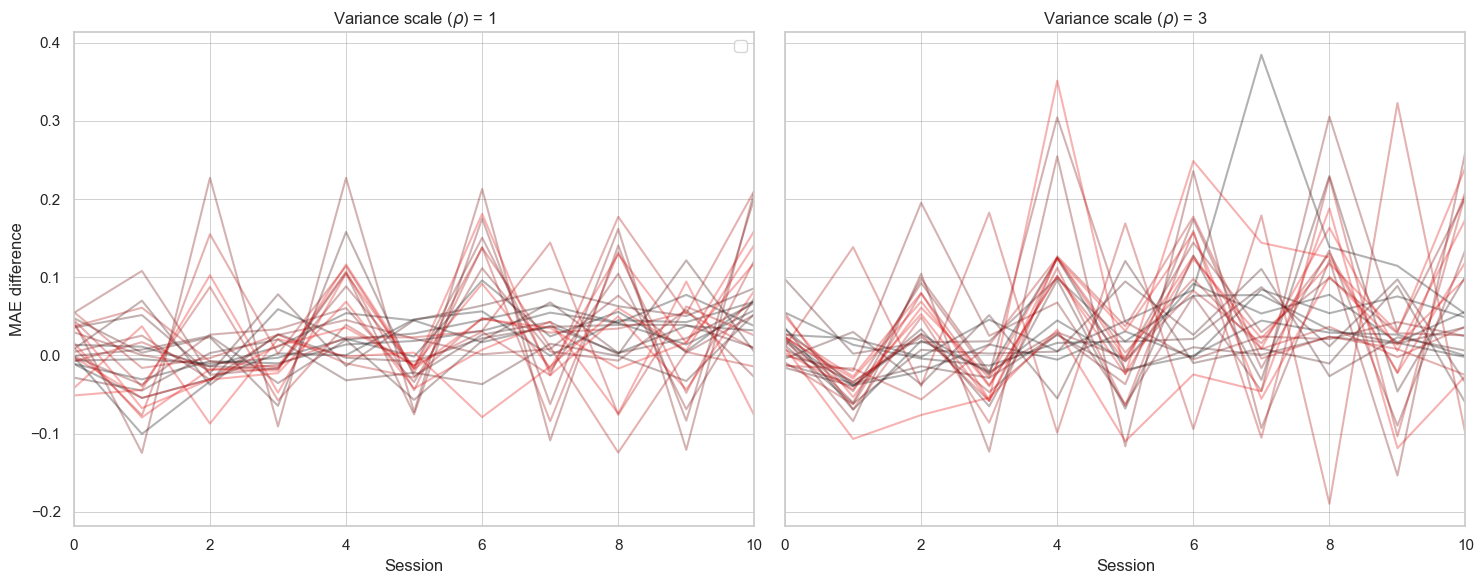

In [476]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6), sharey=True)

diff_mae_1 = cond_baseline_df_a1.maes.values - df_a1.maes.values
diff_mae_3 = cond_baseline_df_a3.maes.values - df_a3.maes.values

for i, rwd in enumerate(diff_mae_1):
    rwd = rwd[~np.isnan(rwd)]
    noise = cond_baseline_df_a1.iloc[i].noise
    color = (noise, 0, 0)
    axs[0].plot(rwd, color=color, alpha=0.3, zorder=2)

for i, rwd in enumerate(diff_mae_3):
    rwd = rwd[~np.isnan(rwd)]
    noise = cond_baseline_df_a3.iloc[i].noise
    color = (noise, 0, 0)
    axs[1].plot(rwd, color=color, alpha=0.3, zorder=2)

axs[0].set_xlabel("Session")
axs[0].set_ylabel("MAE difference")
axs[0].set_title(r"Variance scale ($\rho$) = 1")
axs[1].set_xlabel("Session")
# axs[1].set_ylabel("reward")
axs[1].set_title(r"Variance scale ($\rho$) = 3")

# add grid in background
axs[0].grid(color='gray', linestyle='-', linewidth=0.5, alpha=0.5, zorder=1)
axs[1].grid(color='gray', linestyle='-', linewidth=0.5, alpha=0.5, zorder=1)
axs[0].set_axisbelow(True)
axs[0].set_xlim(0, 10)
# axs[0].set_ylim(0, 1.)
axs[1].set_xlim(0, 10)

axs[0].legend()

# Show the plot
plt.tight_layout()
plt.show()

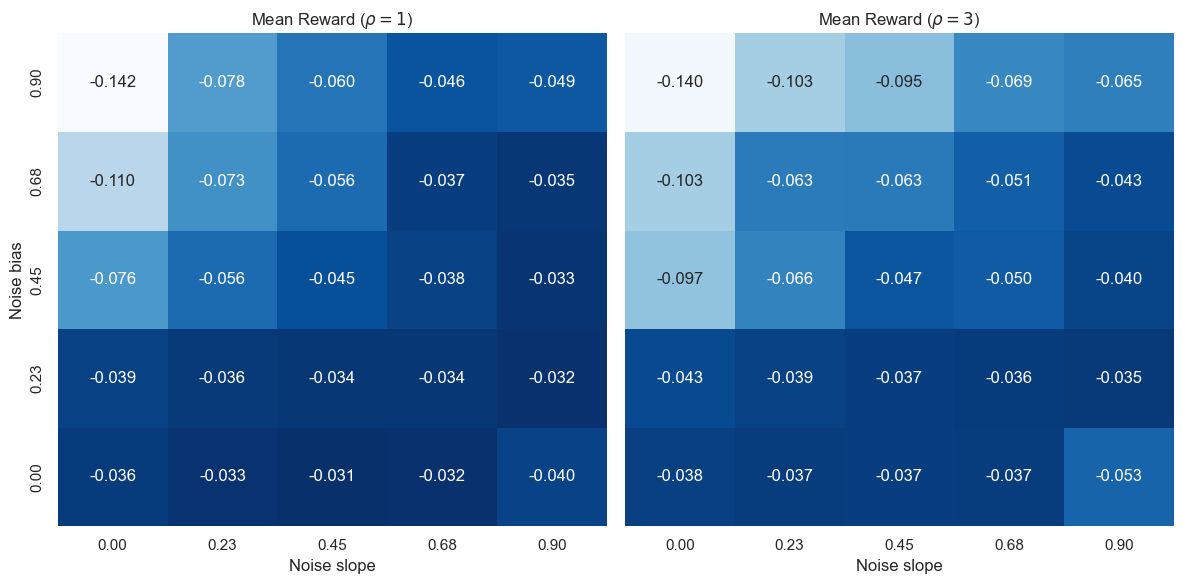

In [477]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

cmap = 'Blues'
vmin = cond_baseline_df.mean_rewards.min()
vmax = cond_baseline_df.mean_rewards.max()

cond_baseline_df_a1_plot = cond_baseline_df_a1.pivot(index='noise', columns='noise_slope', values='mean_rewards').sort_index(ascending=False)
cond_baseline_df_a3_plot = cond_baseline_df_a3.pivot(index='noise', columns='noise_slope', values='mean_rewards').sort_index(ascending=False)
sns.heatmap(cond_baseline_df_a1_plot,
            annot=True, cbar=False, fmt=".3f", cmap=cmap, ax=axs[0], vmin=vmin, vmax=vmax)
sns.heatmap(cond_baseline_df_a3_plot,
            annot=True, cbar=False, fmt=".3f", cmap=cmap, ax=axs[1], vmin=vmin, vmax=vmax)

axs[0].set_title(r"Mean Reward ($\rho=1$)")
axs[1].set_title(r"Mean Reward ($\rho=3$)")

# round ticks
axs[0].set_xticklabels([f"{x:.2f}" for x in cond_baseline_df_a1_plot.index.sort_values()])
axs[0].set_yticklabels([f"{x:.2f}" for x in cond_baseline_df_a1_plot.columns.sort_values(ascending=False)])
axs[1].set_xticklabels([f"{x:.2f}" for x in cond_baseline_df_a3_plot.index.sort_values()])

axs[0].set_xlabel("Noise slope")
axs[0].set_ylabel("Noise bias")
axs[1].set_xlabel("Noise slope")
axs[1].set_ylabel("")

plt.tight_layout()
plt.show()

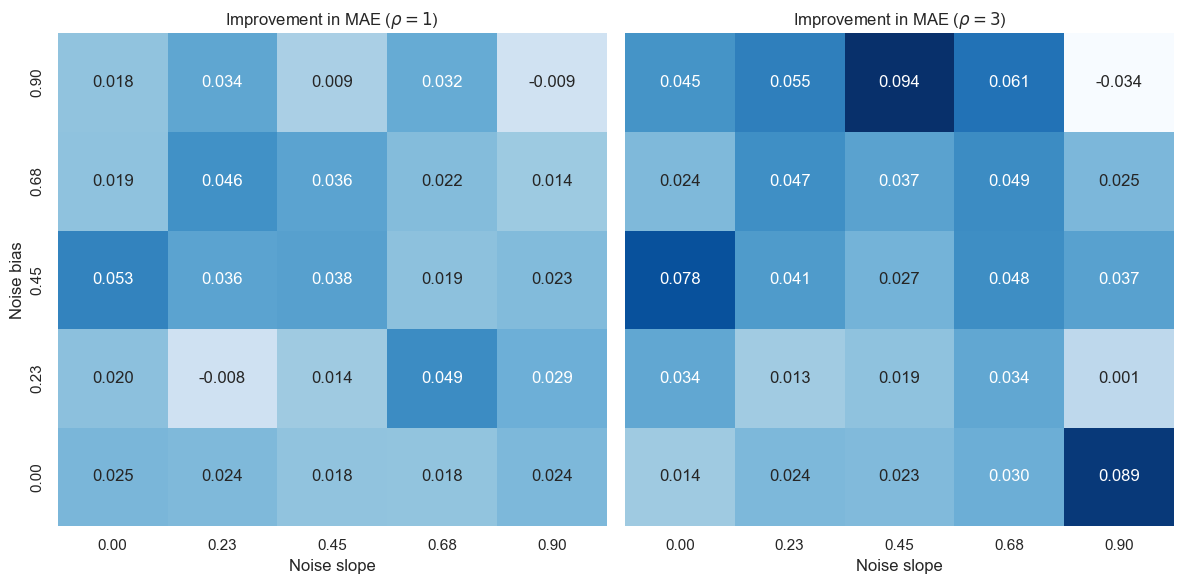

In [478]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

cmap = 'Blues'

df_a1_plot = df_a1.pivot(index='noise', columns='noise_slope', values='mean_mae').sort_index(ascending=False)
df_a3_plot = df_a3.pivot(index='noise', columns='noise_slope', values='mean_mae').sort_index(ascending=False)

cond_baseline_df_a1_plot = cond_baseline_df_a1.pivot(index='noise', columns='noise_slope', values='mean_mae').sort_index(ascending=False)
cond_baseline_df_a3_plot = cond_baseline_df_a3.pivot(index='noise', columns='noise_slope', values='mean_mae').sort_index(ascending=False)

# cond_diff_a1 = (cond_baseline_df_a1_plot / df_a1_plot) - 1 
# cond_diff_a3 = (cond_baseline_df_a3_plot / df_a3_plot) - 1 

cond_diff_a1 = cond_baseline_df_a1_plot - df_a1_plot 
cond_diff_a3 = cond_baseline_df_a3_plot - df_a3_plot 

vmin = min([cond_diff_a1.min().min(), cond_diff_a3.min().min()])
vmax = max([cond_diff_a1.max().max(), cond_diff_a3.max().max()])

sns.heatmap(cond_diff_a1,
            annot=True, cbar=False, fmt=".3f", cmap=cmap, ax=axs[0], vmin=vmin, vmax=vmax)
sns.heatmap(cond_diff_a3,
            annot=True, cbar=False, fmt=".3f", cmap=cmap, ax=axs[1], vmin=vmin, vmax=vmax)

axs[0].set_title(r"Improvement in MAE ($\rho=1$)")
axs[1].set_title(r"Improvement in MAE ($\rho=3$)")

# round ticks
axs[0].set_xticklabels([f"{x:.2f}" for x in cond_diff_a1.index.sort_values()])
axs[0].set_yticklabels([f"{x:.2f}" for x in cond_diff_a1.columns.sort_values(ascending=False)])
axs[1].set_xticklabels([f"{x:.2f}" for x in cond_diff_a3.index.sort_values()])

axs[0].set_xlabel("Noise slope")
axs[0].set_ylabel("Noise bias")
axs[1].set_xlabel("Noise slope")
axs[1].set_ylabel("")

plt.tight_layout()
plt.show()

# With learning
From alpha = 3 (initial) to alpha = 1 (last)

In [161]:
# Filter runs by the "beta_sweep" tag
learning_runs = [run for run in runs if "mi_sweep_kl05_learning" in run.tags and run.state == "finished"]

# Output the filtered runs
print(f"Found {len(learning_runs)} runs with the tag 'mi_sweep'.")

Found 25 runs with the tag 'mi_sweep'.


In [164]:
learning_data = defaultdict(list)

for run in learning_runs:
    run_id = run.id
    history = run.history(samples=10000)
    run_results = {
        "noise": run.config["noise_range"][-1],
        "noise_slope": run.config["noise_slope_range"][-1],
        "alpha": run.config["alpha_range"][-1],
        "rewards": history.encoder_reward.values,
        "maes": history.encoder_mae.values,
        "mean_rewards": np.nanmean(history.encoder_reward.values[1:]),
        "last_rewards": np.nanmean(history.encoder_reward.values[-3:]),
        "mean_mae": np.nanmean(history.encoder_mae.values[1:]),
        "last_mae": np.nanmean(history.encoder_mae.values[-3:]),
    }
    for key, value in run_results.items():
        learning_data[key].append(value)

learning_df = pd.DataFrame(learning_data)

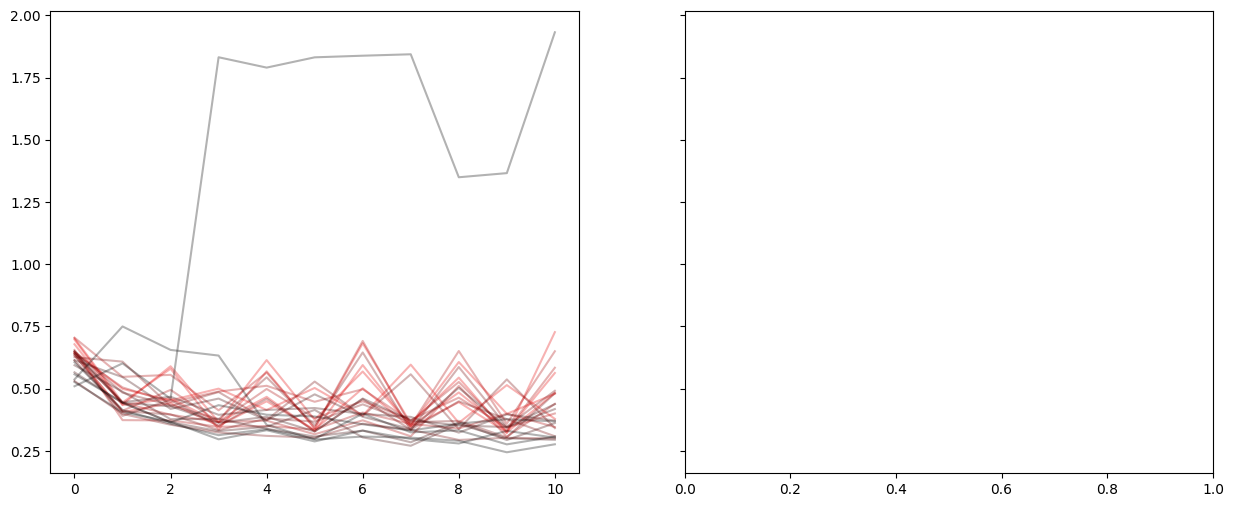

In [165]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6), sharey=True)


for i, rwd in enumerate(learning_df.maes.values):
    rwd = rwd[~np.isnan(rwd)]
    noise = learning_df.iloc[i].noise
    color = (noise, 0, 0)
    axs[0].plot(rwd, color=color, alpha=0.3, zorder=2)

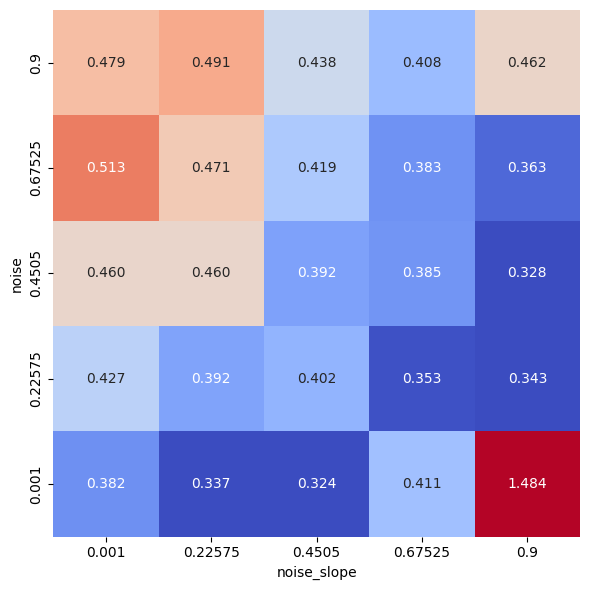

In [168]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(1, 1, figsize=(6, 6), sharey=True)

cmap = 'coolwarm'
vmin = 0.35
vmax = 0.55

learning_plot_df = learning_df.pivot(index='noise', columns='noise_slope', values='mean_mae').sort_index(ascending=False)
sns.heatmap(learning_plot_df,
            annot=True, cbar=False, fmt=".3f", cmap=cmap, ax=ax, vmin=vmin, vmax=vmax)

plt.tight_layout()
plt.savefig('../figures/mi_iter_mean_reward.png', dpi=400)
plt.show()

# Deterministic noise drift

In [285]:
# Filter runs by the "beta_sweep" tag
noise_drift_runs = [run for run in runs if "mi_sweep_kl05_noise_drift" in run.tags and run.state == "finished"]

# Output the filtered runs
print(f"Found {len(noise_drift_runs)} runs with the tag 'mi_sweep'.")

Found 50 runs with the tag 'mi_sweep'.


In [281]:
noise_drift_data = defaultdict(list)

for run in noise_drift_runs:
    run_id = run.id
    history = run.history(samples=10000)
    run_results = {
        "noise": run.config["noise_range"][-1],
        "noise_slope": run.config["noise_slope_range"][-1],
        "alpha": run.config["alpha_range"][-1],
        "rewards": history.encoder_reward.values,
        "maes": history.encoder_mae.values,
        "mean_rewards": np.nanmean(history.encoder_reward.values[1:]),
        "last_rewards": np.nanmean(history.encoder_reward.values[-3:]),
        "mean_mae": np.nanmean(history.encoder_mae.values[1:]),
        "last_mae": np.nanmean(history.encoder_mae.values[-3:]),
    }
    for key, value in run_results.items():
        noise_drift_data[key].append(value)

noise_drift_df = pd.DataFrame(noise_drift_data)

In [369]:
noise_drift_df_a1 = noise_drift_df[noise_drift_df['alpha'] == 1.0]
noise_drift_df_a3 = noise_drift_df[noise_drift_df['alpha'] == 3.0]

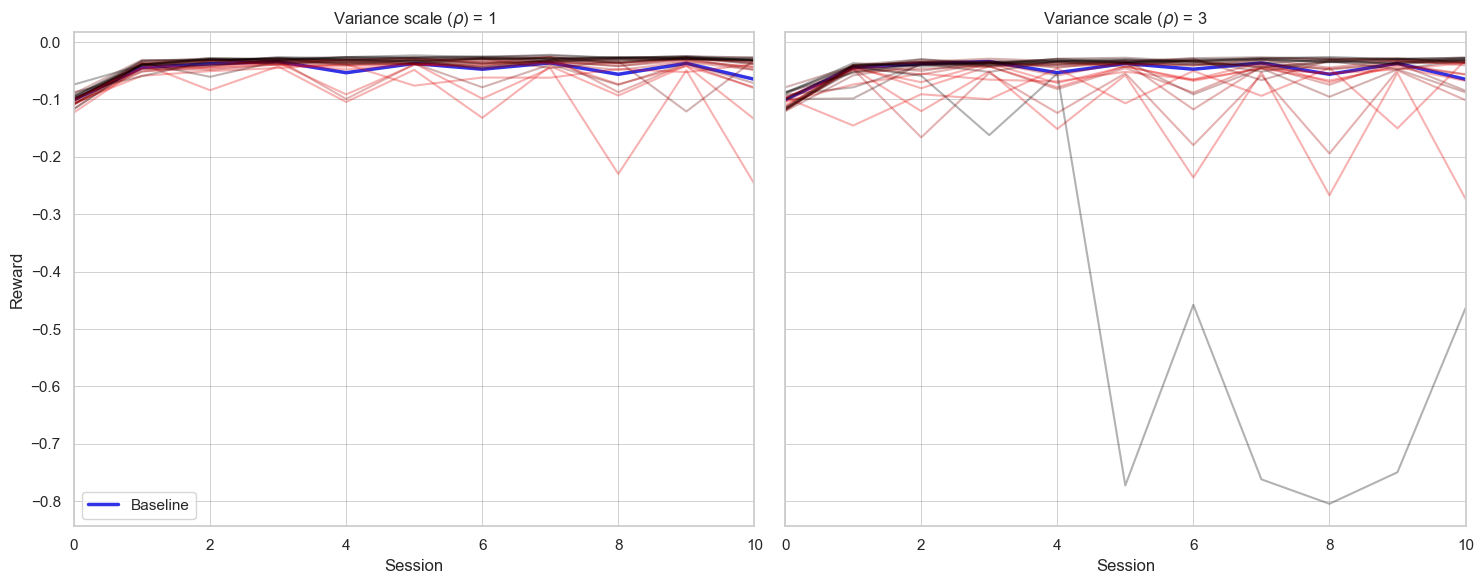

In [370]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6), sharey=True)

# plot baseline
base_color = (.2, .2, .9)
base_reward = base_df.rewards.values[0]
base_reward = base_reward[~np.isnan(base_reward)]
axs[0].plot(base_reward, color=base_color, alpha=1.0, zorder=2, linewidth=2.5, label='Baseline')
axs[1].plot(base_reward, color=base_color, alpha=1.0, zorder=2, linewidth=2.5, label='Baseline')

for i, rwd in enumerate(noise_drift_df_a1.rewards.values):
    rwd = rwd[~np.isnan(rwd)]
    noise = noise_drift_df_a1.iloc[i].noise
    color = (noise, 0, 0)
    axs[0].plot(rwd, color=color, alpha=0.3, zorder=2)

for i, rwd in enumerate(noise_drift_df_a3.rewards.values):
    rwd = rwd[~np.isnan(rwd)]
    noise = noise_drift_df_a3.iloc[i].noise
    color = (noise, 0, 0)
    axs[1].plot(rwd, color=color, alpha=0.3, zorder=2)

axs[0].set_xlabel("Session")
axs[0].set_ylabel("Reward")
axs[0].set_title(r"Variance scale ($\rho$) = 1")
axs[1].set_xlabel("Session")
# axs[1].set_ylabel("reward")
axs[1].set_title(r"Variance scale ($\rho$) = 3")

# add grid in background
axs[0].grid(color='gray', linestyle='-', linewidth=0.5, alpha=0.5, zorder=1)
axs[1].grid(color='gray', linestyle='-', linewidth=0.5, alpha=0.5, zorder=1)
axs[0].set_axisbelow(True)
axs[0].set_xlim(0, 10)
# axs[0].set_ylim(0, 1.)
axs[1].set_xlim(0, 10)

axs[0].legend()

# Show the plot
plt.tight_layout()
# plt.savefig('../figures/mi_iter_rwd_per_episode.png', dpi=400)
plt.show()

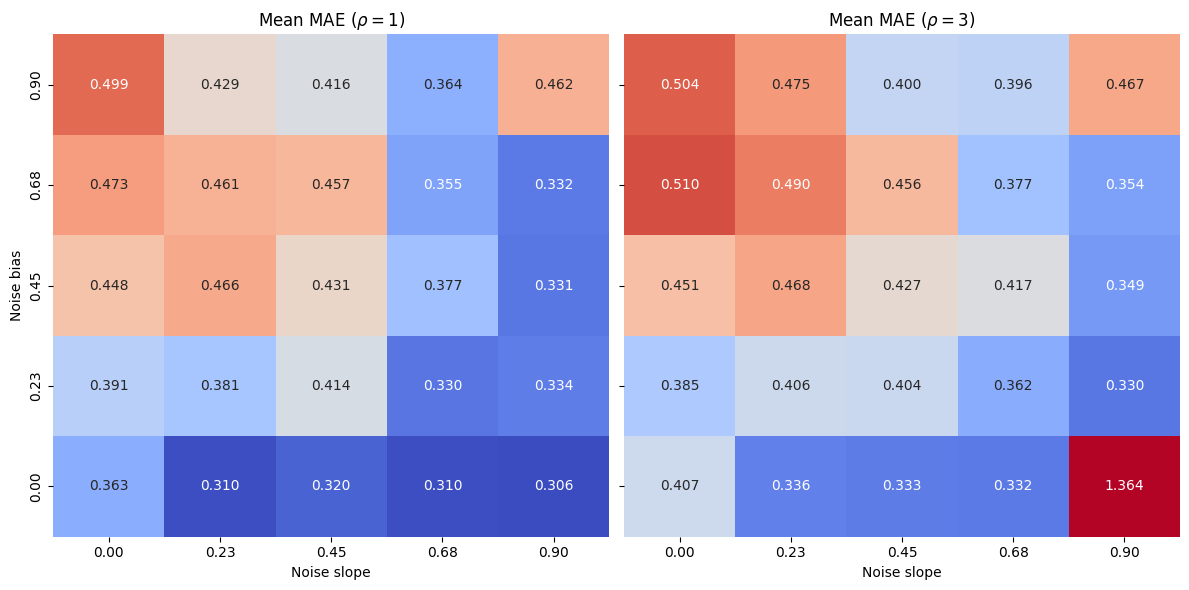

In [284]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

cmap = 'coolwarm'
vmin = df.mean_mae.min()
vmax = df.mean_mae.max()

noise_drift_df_a1_plot = noise_drift_df_a1.pivot(index='noise', columns='noise_slope', values='mean_mae').sort_index(ascending=False)
noise_drift_df_a3_plot = noise_drift_df_a3.pivot(index='noise', columns='noise_slope', values='mean_mae').sort_index(ascending=False)
sns.heatmap(noise_drift_df_a1_plot,
            annot=True, cbar=False, fmt=".3f", cmap=cmap, ax=axs[0], vmin=vmin, vmax=vmax)
sns.heatmap(noise_drift_df_a3_plot,
            annot=True, cbar=False, fmt=".3f", cmap=cmap, ax=axs[1], vmin=vmin, vmax=vmax)

axs[0].set_title(r"Mean MAE ($\rho=1$)")
axs[1].set_title(r"Mean MAE ($\rho=3$)")

# round ticks
axs[0].set_xticklabels([f"{x:.2f}" for x in noise_drift_df_a1_plot.index.sort_values()])
axs[0].set_yticklabels([f"{x:.2f}" for x in noise_drift_df_a1_plot.columns.sort_values(ascending=False)])
axs[1].set_xticklabels([f"{x:.2f}" for x in noise_drift_df_a3_plot.index.sort_values()])

axs[0].set_xlabel("Noise slope")
axs[0].set_ylabel("Noise bias")
axs[1].set_xlabel("Noise slope")
axs[1].set_ylabel("")

plt.tight_layout()
# plt.savefig('../figures/mi_iter_mean_mae.png', dpi=400)
plt.show()

# Drift

In [288]:
# Filter runs by the "beta_sweep" tag
noise_drift_runs = [run for run in runs if "mi_sweep_kl05_drift" in run.tags and run.state == "finished"]

# Output the filtered runs
print(f"Found {len(noise_drift_runs)} runs with the tag 'mi_sweep'.")

Found 50 runs with the tag 'mi_sweep'.


In [289]:
noise_drift_data = defaultdict(list)

for run in noise_drift_runs:
    run_id = run.id
    history = run.history(samples=10000)
    run_results = {
        "noise": run.config["noise_range"][-1],
        "noise_slope": run.config["noise_slope_range"][-1],
        "alpha": run.config["alpha_range"][-1],
        "rewards": history.encoder_reward.values,
        "maes": history.encoder_mae.values,
        "mean_rewards": np.nanmean(history.encoder_reward.values[1:]),
        "last_rewards": np.nanmean(history.encoder_reward.values[-3:]),
        "mean_mae": np.nanmean(history.encoder_mae.values[1:]),
        "last_mae": np.nanmean(history.encoder_mae.values[-3:]),
    }
    for key, value in run_results.items():
        noise_drift_data[key].append(value)

noise_drift_df = pd.DataFrame(noise_drift_data)

In [290]:
noise_drift_df_a1 = noise_drift_df[noise_drift_df['alpha'] == 1.0]
noise_drift_df_a3 = noise_drift_df[noise_drift_df['alpha'] == 3.0]

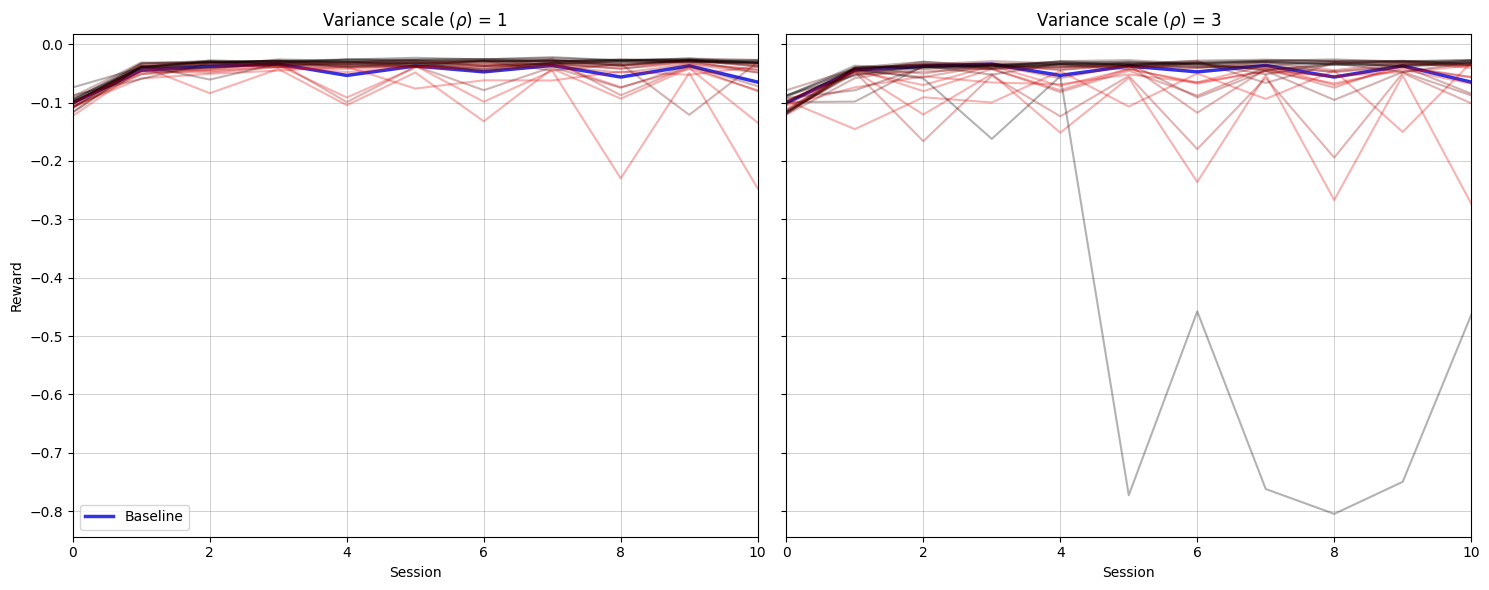

In [291]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6), sharey=True)

# plot baseline
base_color = (.2, .2, .9)
base_reward = base_df.rewards.values[0]
base_reward = base_reward[~np.isnan(base_reward)]
axs[0].plot(base_reward, color=base_color, alpha=1.0, zorder=2, linewidth=2.5, label='Baseline')
axs[1].plot(base_reward, color=base_color, alpha=1.0, zorder=2, linewidth=2.5, label='Baseline')

for i, rwd in enumerate(noise_drift_df_a1.rewards.values):
    rwd = rwd[~np.isnan(rwd)]
    noise = noise_drift_df_a1.iloc[i].noise
    color = (noise, 0, 0)
    axs[0].plot(rwd, color=color, alpha=0.3, zorder=2)

for i, rwd in enumerate(noise_drift_df_a3.rewards.values):
    rwd = rwd[~np.isnan(rwd)]
    noise = noise_drift_df_a3.iloc[i].noise
    color = (noise, 0, 0)
    axs[1].plot(rwd, color=color, alpha=0.3, zorder=2)

axs[0].set_xlabel("Session")
axs[0].set_ylabel("Reward")
axs[0].set_title(r"Variance scale ($\rho$) = 1")
axs[1].set_xlabel("Session")
# axs[1].set_ylabel("reward")
axs[1].set_title(r"Variance scale ($\rho$) = 3")

# add grid in background
axs[0].grid(color='gray', linestyle='-', linewidth=0.5, alpha=0.5, zorder=1)
axs[1].grid(color='gray', linestyle='-', linewidth=0.5, alpha=0.5, zorder=1)
axs[0].set_axisbelow(True)
axs[0].set_xlim(0, 10)
# axs[0].set_ylim(0, 1.)
axs[1].set_xlim(0, 10)

axs[0].legend()

# Show the plot
plt.tight_layout()
# plt.savefig('../figures/mi_iter_rwd_per_episode.png', dpi=400)
plt.show()

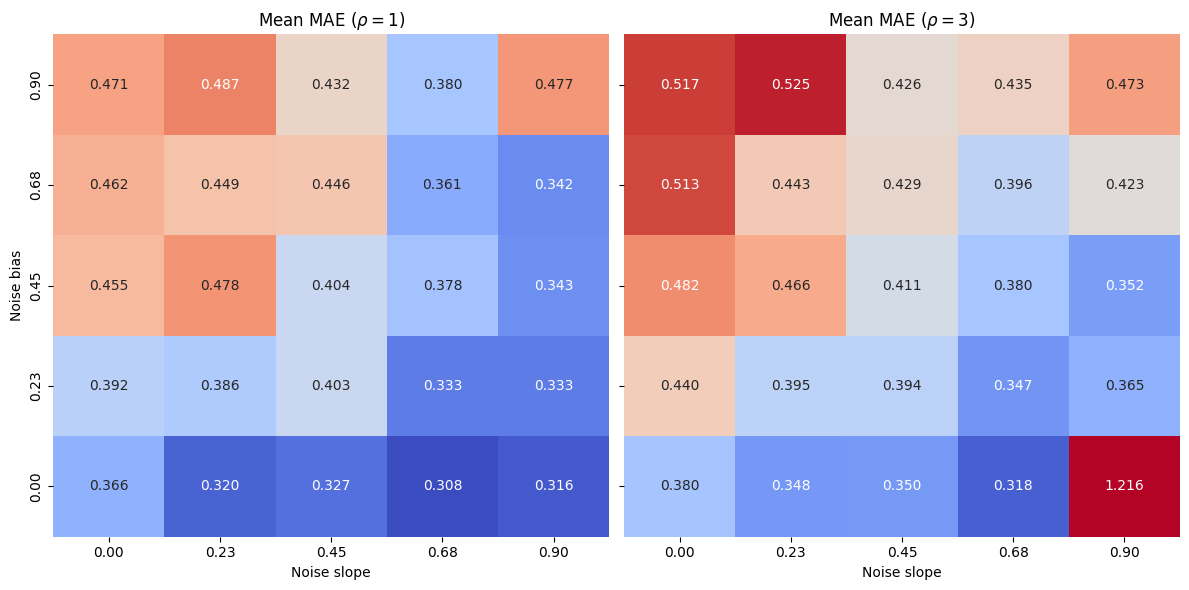

In [292]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

cmap = 'coolwarm'
vmin = df.mean_mae.min()
vmax = df.mean_mae.max()

noise_drift_df_a1_plot = noise_drift_df_a1.pivot(index='noise', columns='noise_slope', values='mean_mae').sort_index(ascending=False)
noise_drift_df_a3_plot = noise_drift_df_a3.pivot(index='noise', columns='noise_slope', values='mean_mae').sort_index(ascending=False)
sns.heatmap(noise_drift_df_a1_plot,
            annot=True, cbar=False, fmt=".3f", cmap=cmap, ax=axs[0], vmin=vmin, vmax=vmax)
sns.heatmap(noise_drift_df_a3_plot,
            annot=True, cbar=False, fmt=".3f", cmap=cmap, ax=axs[1], vmin=vmin, vmax=vmax)

axs[0].set_title(r"Mean MAE ($\rho=1$)")
axs[1].set_title(r"Mean MAE ($\rho=3$)")

# round ticks
axs[0].set_xticklabels([f"{x:.2f}" for x in noise_drift_df_a1_plot.index.sort_values()])
axs[0].set_yticklabels([f"{x:.2f}" for x in noise_drift_df_a1_plot.columns.sort_values(ascending=False)])
axs[1].set_xticklabels([f"{x:.2f}" for x in noise_drift_df_a3_plot.index.sort_values()])

axs[0].set_xlabel("Noise slope")
axs[0].set_ylabel("Noise bias")
axs[1].set_xlabel("Noise slope")
axs[1].set_ylabel("")

plt.tight_layout()
# plt.savefig('../figures/mi_iter_mean_mae.png', dpi=400)
plt.show()